TODO
- Use sample min instead of 0
- Fit separate spline to lower tail

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import scipy.stats
import math

from utils import *
from models import *

# Sampling distribution of Lorenz curves

More unequal going down, G = [ 0.25  0.4   0.55]
Larger sample going across, N = [250, 1000, 5000, 20000]


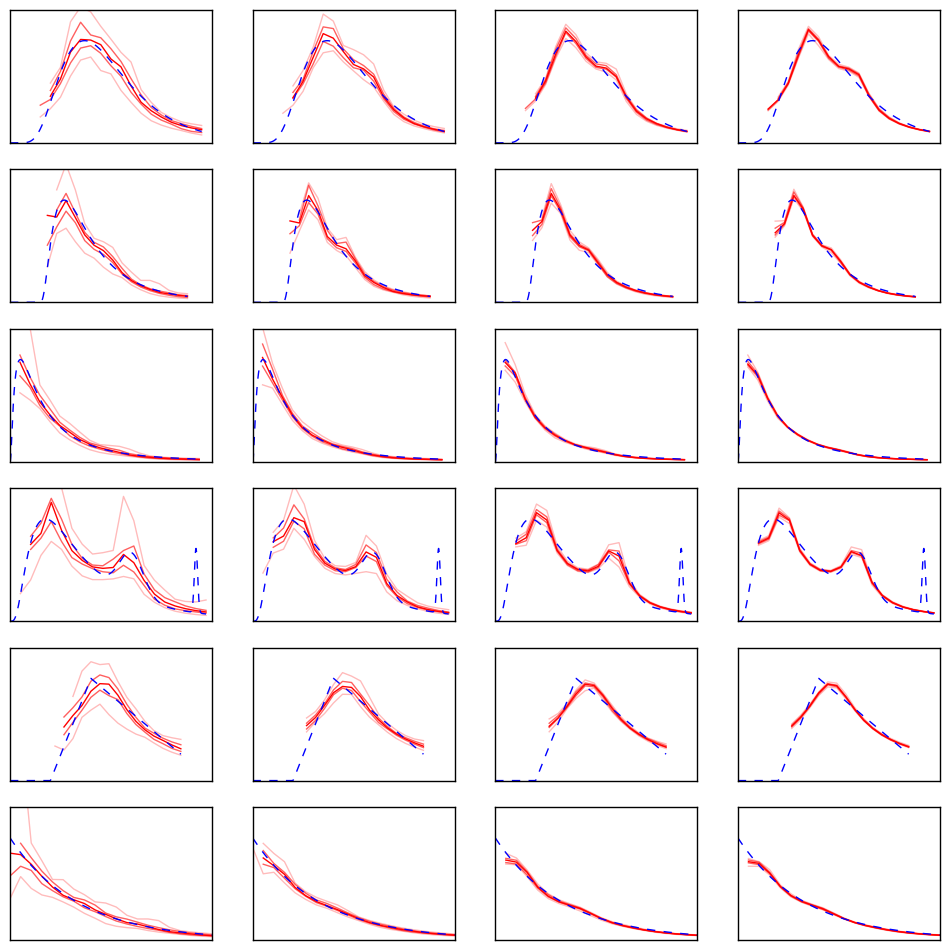

In [33]:
N_arr = [250,1000,5000,20000]

Gs = np.array([0.25, 0.40, 0.55])
locs = np.array([0, 5000, 0])
mean = 10000
sigmas = scipy.stats.norm.ppf((Gs + 1)/2, 0, 1) * math.sqrt(2)
mus = math.log(mean) - 0.5 * sigmas ** 2

dist_arr = (
    [scipy.stats.lognorm(sigma, loc=loc, scale=math.exp(mu)) for sigma, mu, loc in zip(sigmas, mus, locs)] + 
    [
        MixtureDistribution([
            (0.85, scipy.stats.lognorm(sigmas[1], scale=math.exp(mus[1]))),
            (0.125, scipy.stats.norm(15000, 1500)),
            (0.025, scipy.stats.norm(23000, 200))
        ]),
        scipy.stats.triang(0.25, loc=5000, scale=20000),
        scipy.stats.expon(scale=mean)
    ]
)

M = 20 # number of monte carlo trials
P = 20  # number of points on Lorenz curve to sample

plot_quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

##########################################
plt.rcParams["figure.figsize"] = (3*len(N_arr),2*len(dist_arr))
fig, axs = plt.subplots(len(dist_arr), len(N_arr))
##########################################

# Break this apart we can use progress bar
work = list()
for axrow, dist in zip(axs, dist_arr):
    for ax, N in zip(axrow, N_arr):
        work.append((ax, dist, N))
        
for ax, dist, N in log_progress(work):
    # We have a discrete sample, so we can't necessarily sample at exactly the points demanded by P 
    lorenz_index = [round(i / P * N)-1 for i in range(1,P+1)]
    lorenz_p = [(i+1)/N for i in lorenz_index]
    lorenz_dp = np.diff(np.insert(lorenz_p, 0, 0)) # used in Gini calc
    lorenz_L = np.empty([M, P])

    pdf_y = np.linspace(0, dist.ppf(0.95), P)
    pdf_p = np.empty([M, P])

    for m in range(M):
        # Generate sample
        sample = dist.rvs(N)
        sample_mean = np.mean(sample)
        sample_min = np.min(sample)

        # Empirical Lorenz curve
        sample_sorted = np.sort(sample)
        sample_cumul = np.cumsum(sample_sorted)
        sample_L = sample_cumul[lorenz_index] / sample_cumul[-1]
        lorenz_L[m, :] = sample_L

        if False:
            sample_G = 1 - sum(0.5 * lorenz_dp * (np.insert(sample_L,0,0)[:-1] + sample_L)) / 0.5
            sample_sigma = scipy.stats.norm.ppf((sample_G + 1)/2, 0, 1) * math.sqrt(2);
            sample_mu = math.log(sample_mean) - 0.5 * sample_sigma ** 2;
            sample_lnorm_p = scipy.stats.lognorm.pdf(pdf_y, sample_sigma, scale=math.exp(sample_mu))
            pdf_p[m, :] = sample_lnorm_p
        else:
            spline = SplineLorenzDistribution(
                np.insert(lorenz_p,0,0),
                np.insert(sample_L,0,0),
                sample_mean,
                smoothing=1e-7, #7 best
                sample_N = N,
                sample_min = sample_min
            )
            sample_spline_p = spline.pdf(pdf_y)
            pdf_p[m, :] = sample_spline_p

    # Now we've collected the points, we need to sort so that we can calculate quantiles over
    # the monte carlo trials
    for i in range(P):
        lorenz_L[:, i] = np.sort(lorenz_L[:, i])
        pdf_p[:, i] = np.sort(pdf_p[:, i])

    for q in plot_quantiles:
        #ax.plot(lorenz_p, lorenz_L[round(M*q), :], color=(1,0,0,1-abs(0.5-q)*1.5))
        ax.plot(pdf_y, pdf_p[int(M*q), :], color=(1,0,0,1-abs(0.5-q)*1.5))
    grid_y = np.linspace(0, dist.ppf(0.95), 1000)
    ax.plot(grid_y, dist.pdf(grid_y), color="blue", linestyle="dashed")
    ax.set_ylim(0, np.max(dist.pdf(grid_y))*1.3)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
            
print("More unequal going down, G = {}".format(Gs))
print("Larger sample going across, N = {}".format(N_arr))

(0, 1.0759159549926621e-06)

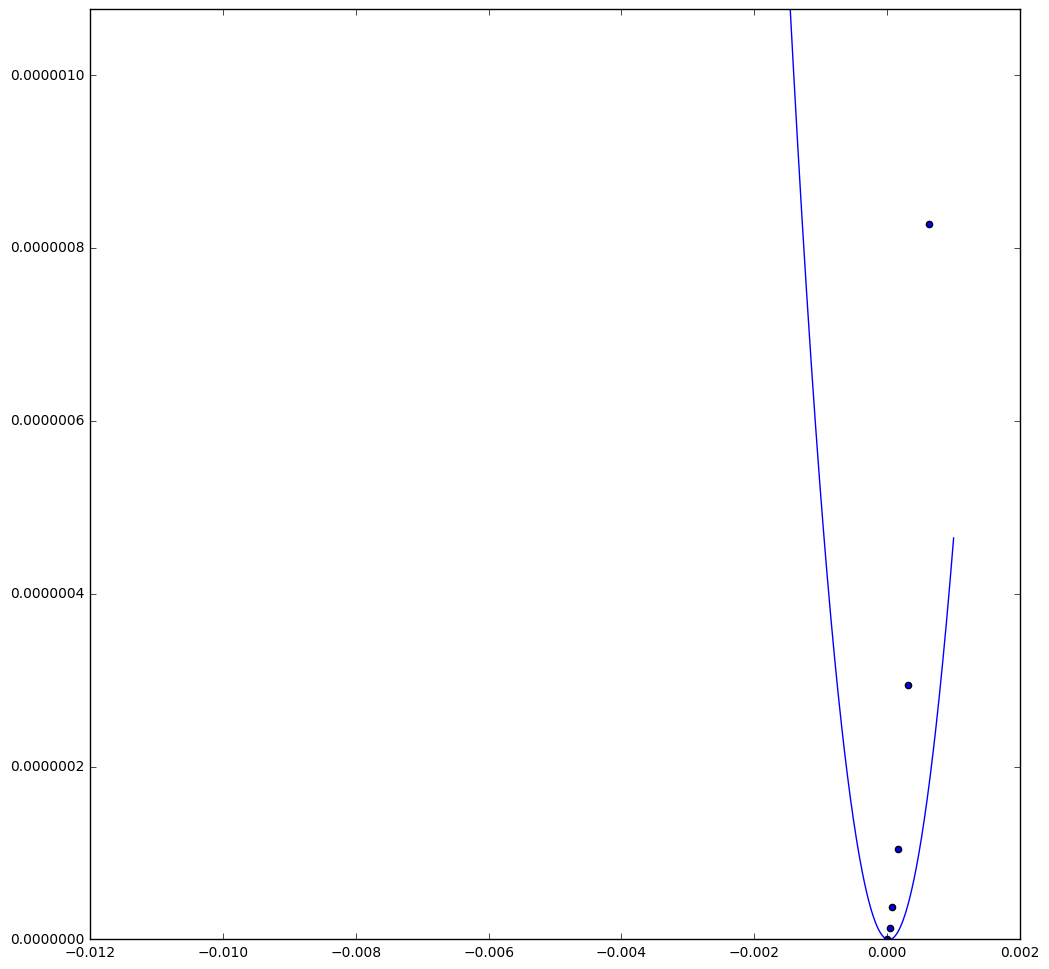

In [29]:
ulimit = 0.01
pgrid = np.linspace(-.01, ulimit, 1000)
plt.plot(pgrid, spline.lorenz(pgrid))
plt.scatter(spline.p[spline.p < ulimit], spline.L[spline.p < ulimit])
plt.ylim(0, np.max(spline.L[spline.p < ulimit])*1.3)

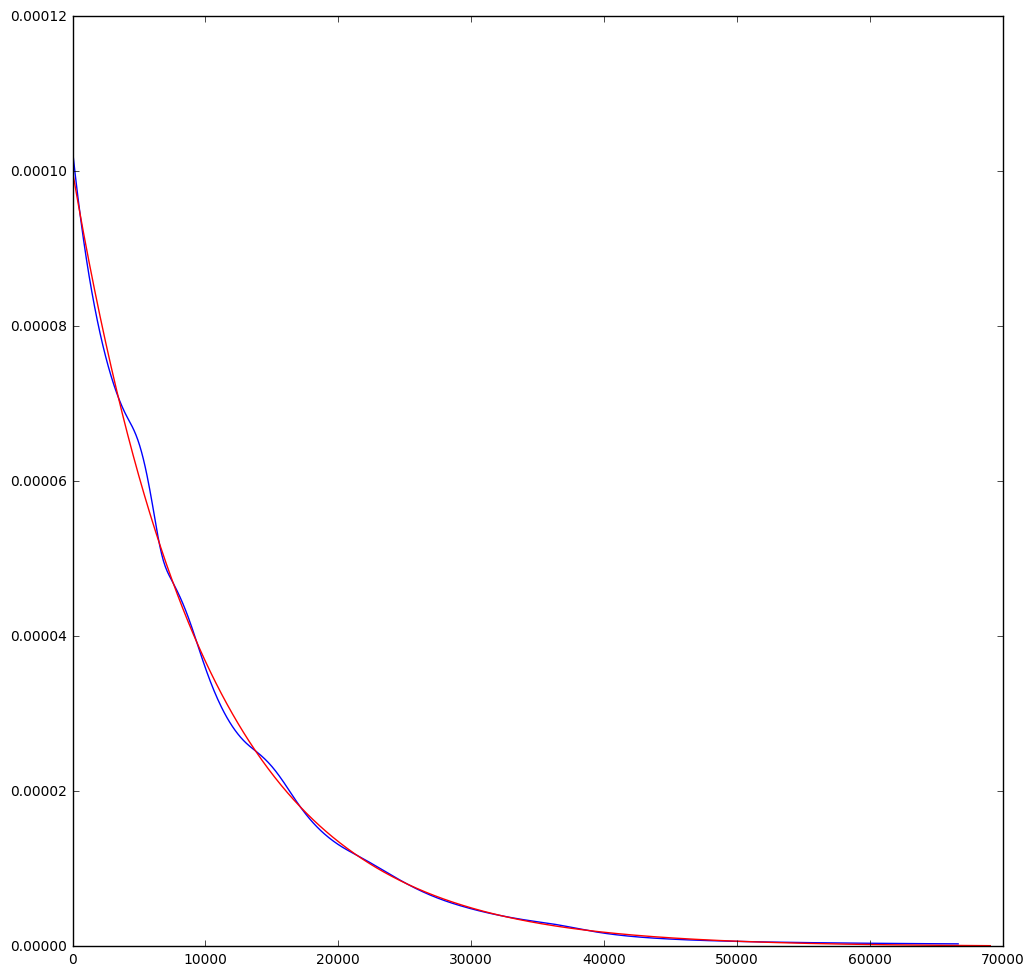

In [30]:
grid_y = np.linspace(0, dist.ppf(0.999), 1000)

plt.plot(grid_y, spline.pdf(grid_y))
plt.plot(grid_y, dist.pdf(grid_y), color="r")
#plt.scatter(spline.quantile(spline.p), spline.pdf(spline.quantile(spline.p)))

In [15]:
spline.quantile(0)

5466.8251835337114

In [ ]:
np.exp(np.linspace(np.log(1),np.log(11),10))-1

In [ ]:
dist.ppf(1e-7)

In [ ]:
(2 ** -np.array(range(10,1,-1)))

In [ ]:
2.0 ** np.array(range(8,0,-1))